<h1 style="font-family:Times New Roman; font-size: 300%"><center>FYS5419 Quantum Computing and Quantum Machine learning</center></h1>
<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Project 1</h2>

<p style="font-family:Times New Roman; font-size:120%">
    The following notebook is my code submission for project 1 in FYS5419, presenting how VQE is an effective numerical approach, yielding exact analytical results.
</p>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
np.set_printoptions(precision=3)
plt.style.use('/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/modulo')

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Task a</h2>

In [2]:
# Define basis states
zero = np.array([1, 0], dtype=complex)
one  = np.array([0, 1], dtype=complex)

# Define Pauli matrices
X = np.array([[0, 1],
              [1, 0]], dtype=complex)
Y = np.array([[0, -1j],
              [1j, 0]], dtype=complex)
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)

# Define Hadamard and Phase (S) gates
H = (1/np.sqrt(2)) * np.array([[1, 1],
                               [1, -1]], dtype=complex)
S = np.array([[1, 0],
              [0, 1j]], dtype=complex)

# Effects on |0> and |1>
print("X|0> =", X @ zero)
print("Y|0> =", Y @ zero)
print("Z|0> =", Z @ zero)

print("Hadamard on |0> =", H @ zero)
print("Hadamard on |1> =", H @ one)
print("Phase on |1> =", S @ one)


X|0> = [0.+0.j 1.+0.j]
Y|0> = [0.+0.j 0.+1.j]
Z|0> = [1.+0.j 0.+0.j]
Hadamard on |0> = [0.707+0.j 0.707+0.j]
Hadamard on |1> = [ 0.707+0.j -0.707+0.j]
Phase on |1> = [0.+0.j 0.+1.j]


<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Task a: CNOT</h2>

In [3]:
# Define basis states for 1 qubit
zero = np.array([1, 0], dtype=complex)
one  = np.array([0, 1], dtype=complex)

# Tensor product function for two qubits
def tensor(a, b):
    return np.kron(a, b)

# Two-qubit |00> state
state_00 = tensor(zero, zero)

# Define single-qubit gates as before
H = (1/np.sqrt(2)) * np.array([[1, 1],
                               [1, -1]], dtype=complex)
I = np.eye(2, dtype=complex)
# Define the CNOT gate in the computational basis ordered as |00>, |01>, |10>, |11>
CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]], dtype=complex)

# Build the two-qubit Hadamard on the first qubit: H ⊗ I
H1 = np.kron(H, I)
state_after_H = H1 @ state_00

# Apply CNOT
bell_state = CNOT @ state_after_H

print("Bell state (|Φ⁺⟩):")
print(bell_state)
# Expected output: (1/√2)[1, 0, 0, 1]^T

# Measurement simulation: define a function to sample from the state
def measure_state(state, shots=1000):
    # Probabilities of measuring each computational basis state
    probs = np.abs(state)**2
    # There are 4 states; use cumulative distribution
    cum_probs = np.cumsum(probs)
    outcomes = []
    for _ in range(shots):
        r = np.random.rand()
        for i, cp in enumerate(cum_probs):
            if r < cp:
                outcomes.append(i)
                break
    return np.bincount(outcomes, minlength=4) / shots

# Simulate measurements
measurement_results = measure_state(bell_state, shots=10000)
print("Measurement probabilities (basis ordering: |00>,|01>,|10>,|11>):")
print(measurement_results)

Bell state (|Φ⁺⟩):
[0.707+0.j 0.   +0.j 0.   +0.j 0.707+0.j]
Measurement probabilities (basis ordering: |00>,|01>,|10>,|11>):
[0.495 0.    0.    0.505]


<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Task b+c:</h2>

<p style="font-family:Times New Roman; font-size:120%">
    This task, I have for illustrative purposes, done in two ways, both being essentially the same. In the first approach, I define the U3 gate eith parameters [\(\phi, \theta\)] and act it on the initial state |0>, producing the ansatz which we are to optimize with VQE. In the second approach, I pre-calculate the ansatz and optimize the parameters directly, which is of course, more efficient numerically. That is precisely why I will proceed with the second approach for the remainer for the project.
</p>

<h2 style="font-family:Times New Roman; font-weight:bold"> Approach 1 </h2>

Optimized parameters:
θ = 3.338977631470978
φ = -5.5541992187502014e-06
VQE Ground State Energy = 0.9801960973391459
Exact Ground State Energy = 0.980196097281443


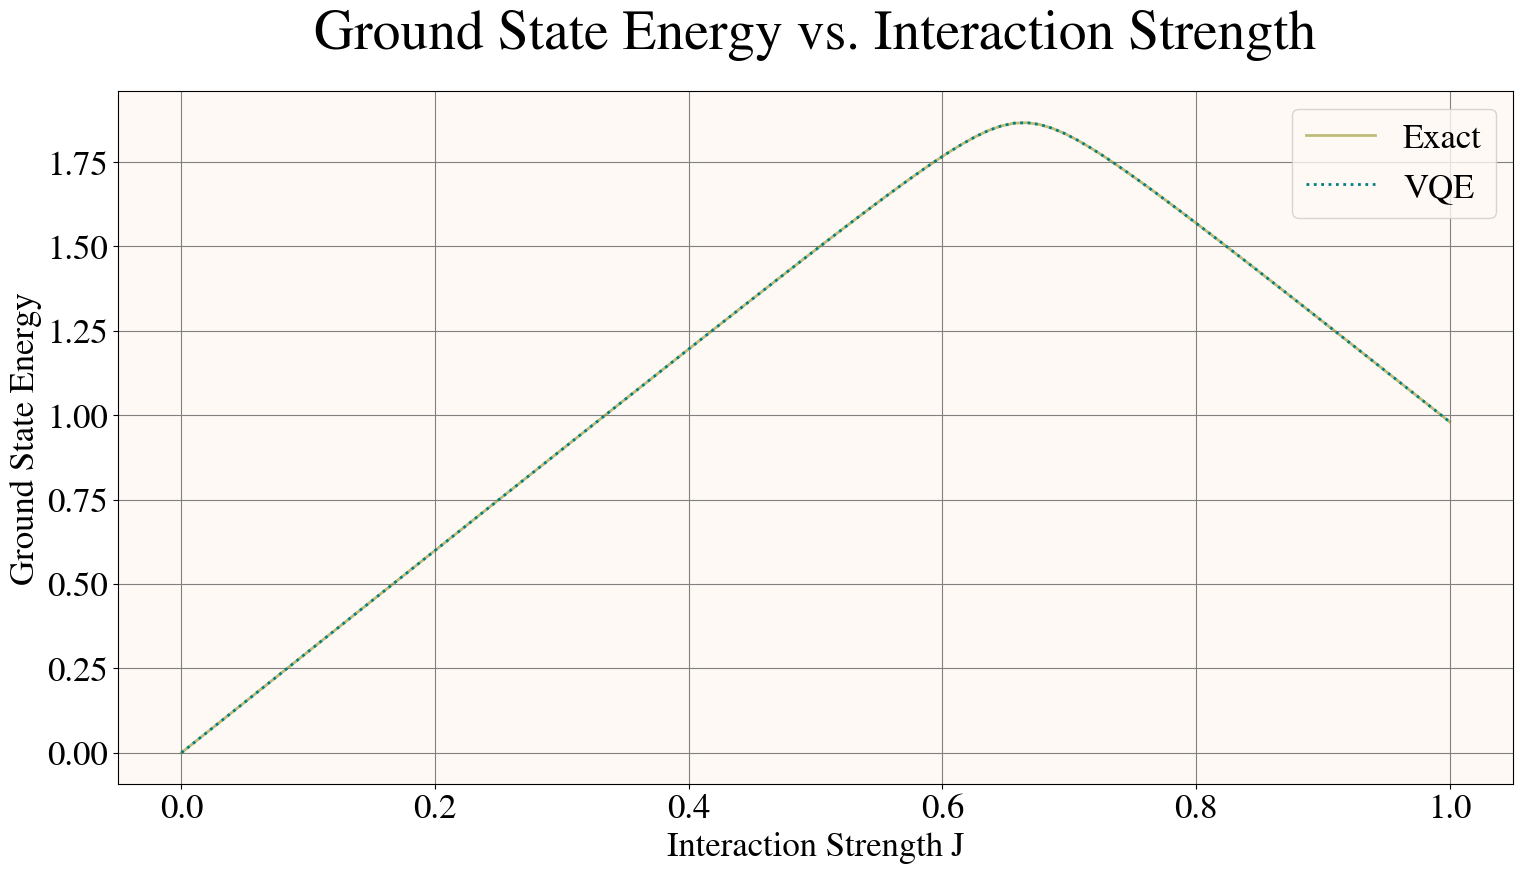

In [61]:
# --- Hamiltonian Decomposition ---
# Task: Express H = [[3, 0.2], [0.2, 1]] as H = 2I + 0.2X + Z.
H = 2 * I + 0.2 * X + Z

# --- U3 Gate Definition ---
def U3(theta, phi, lam=0):
    """
    Constructs the U3 gate matrix.
    For lam = 0, U3(theta, phi, 0) prepares:
    cos(theta/2)|0> + e^(i phi) sin(theta/2)|1>
    """
    return np.array([
        [np.cos(theta/2), -np.exp(1j*lam)*np.sin(theta/2)],
        [np.exp(1j*phi)*np.sin(theta/2), np.exp(1j*(phi+lam))*np.cos(theta/2)]
    ], dtype=complex)

def state_from_U3(theta, phi, lam=0):
    """Applies U3 to the initial state |0>."""
    psi0 = np.array([1, 0], dtype=complex)
    U = U3(theta, phi, lam)
    return U @ psi0

# --- Energy Expectation Function ---
def energy_expectation(params, H):
    """Computes the expectation value <psi|H|psi> for the state prepared by U3."""
    theta, phi = params
    psi = state_from_U3(theta, phi, lam=0)
    return np.real(np.vdot(psi, H @ psi))

# --- VQE Optimization for a Fixed Hamiltonian ---
initial_params = [np.pi/2, 0]
result = minimize(lambda p: energy_expectation(p, H), initial_params, method='Nelder-Mead')
theta_opt, phi_opt = result.x
vqe_energy = energy_expectation([theta_opt, phi_opt], H)

print("Optimized parameters:")
print("θ =", theta_opt)
print("φ =", phi_opt)
print("VQE Ground State Energy =", vqe_energy)

# --- Exact Diagonalization ---
eigvals, _ = np.linalg.eigh(H)
exact_energy = np.min(eigvals)
print("Exact Ground State Energy =", exact_energy)

# --- Sweep over Interaction Strengths ---
# Here we use an alternative Hamiltonian defined as:
# H0 = I*epsilon + omega*Z, HI = c*I + wz*Z + wx*X
E1, E2 = 0, 4
V11, V22 = 3, -3
V12, V21 = 0.2, 0.2

epsilon = 0.5*(E2+E1)  # 2
omega   = 0.5*(E1-E2)  # -2
c       = 0.5*(V11+V22)  # 0
wz      = 0.5*(V11-V22)  # 3
wx      = V12           # 0.2

H0 = I * epsilon + omega * Z  # 2I - 2Z
HI = c * I + wz * Z + wx * X    # 0I + 3Z + 0.2X

J_values = np.linspace(0, 1, 100)  # Use J as a multiplier for HI.
energies_exact = []
energies_vqe = []

for J_val in J_values:
    H_current = H0 + J_val * HI
    eigvals, _ = np.linalg.eigh(H_current)
    E_exact = np.min(eigvals)
    energies_exact.append(E_exact)
    
    res = minimize(lambda p: energy_expectation(p, H_current),
                   initial_params, method='Nelder-Mead')
    theta_opt, phi_opt = res.x
    E_vqe = energy_expectation([theta_opt, phi_opt], H_current)
    energies_vqe.append(E_vqe)


plt.plot(J_values, energies_exact, alpha=0.5, label="Exact")
plt.plot(J_values, energies_vqe, ls="dotted", label="VQE")
plt.xlabel("Interaction Strength J")
plt.ylabel("Ground State Energy")
plt.title("Ground State Energy vs. Interaction Strength")
plt.legend()
plt.grid(True)
plt.show()

<h2 style="font-family:Times New Roman; font-weight:bold"> Approach 2 </h2>

In [5]:
E1=0
E2=4
V11=3
V22=-V11
V12=0.2
V21=V12

epsilon=0.5*(E2+E1)
omega=0.5*(E1-E2)
c = 0.5*(V11+V22)
wz = 0.5*(V11-V22)
wx = V12

H0 = I*epsilon + omega*Z
HI = c*I + wz*Z+wx*X

# Define parameters for the Hamiltonian
l=1

# Define the Lipkin Hamiltonian: H = epsilon*Z - V*X
H = H0+l*HI

# Define the variational ansatz: |ψ(θ, φ)> = cos(θ/2)|0> + e^(iφ) sin(θ/2)|1>
def ansatz_state(theta, phi):
    return np.array([np.cos(theta/2), np.exp(1j*phi)*np.sin(theta/2)], dtype=complex)

# Compute expectation value of H for the ansatz state
def energy_expectation(params):
    theta, phi = params
    psi = ansatz_state(theta, phi)
    energy = np.real(np.vdot(psi, H @ psi))
    return energy

# Initial guess for [theta, phi]
initial_params = [np.pi/2, 0]

# Perform classical optimization
result = minimize(energy_expectation, initial_params, method='Nelder-Mead')
theta_opt, phi_opt = result.x
vqe_energy = energy_expectation([theta_opt, phi_opt])

print("Optimized parameters:")
print("θ =", theta_opt)
print("φ =", phi_opt)
print("VQE Ground State Energy =", vqe_energy)

# Exact diagonalization of H
eigvals, _ = np.linalg.eigh(H)
exact_energy = np.min(eigvals)
print("Exact Ground State Energy =", exact_energy)


Optimized parameters:
θ = 3.338977631470978
φ = -5.5541992187502014e-06
VQE Ground State Energy = 0.9801960973391459
Exact Ground State Energy = 0.980196097281443


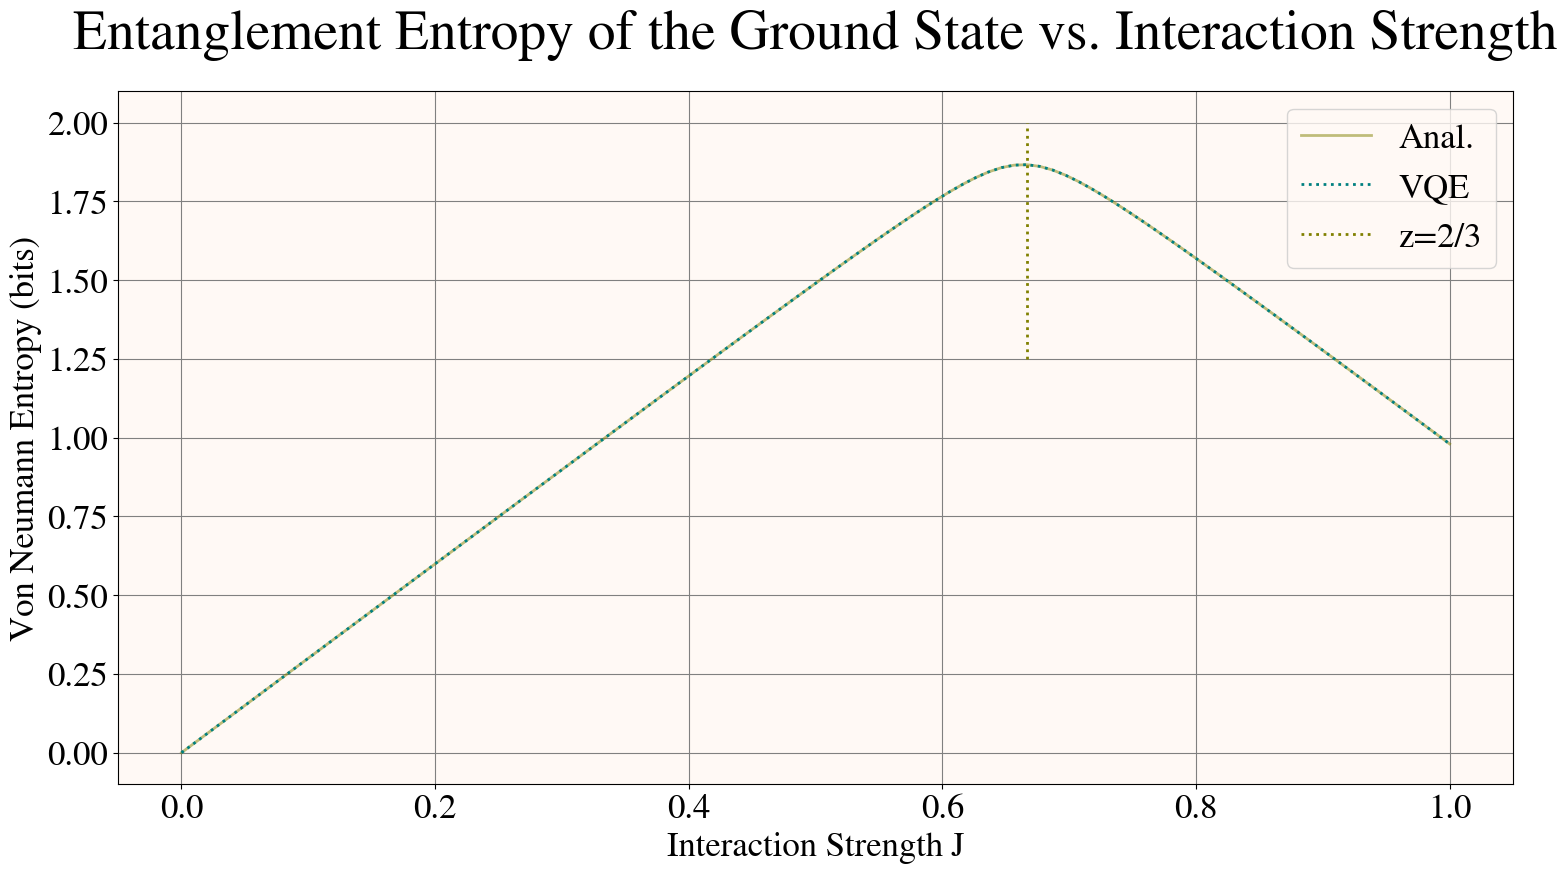

In [6]:
# Set up a range of interaction strengths J
J_values = np.linspace(0, 1, 100)
energies = []
VQEenergies = []

for J in J_values:
    H = H0+J*HI
    # VQE
    result = minimize(energy_expectation, initial_params, method='Nelder-Mead')
    theta_opt, phi_opt = result.x
    vqe_energy = energy_expectation([theta_opt, phi_opt])
    VQEenergies.append(vqe_energy)
    # Exact diagonalization of H
    eigvals, _ = np.linalg.eigh(H)
    exact_energy = np.min(eigvals)
    
    energies.append(exact_energy)

# Plot the von Neumann entropy as a function of the interaction strength J
plt.plot(J_values, energies, alpha=0.5,label="Anal.")
plt.plot(J_values, VQEenergies, ls="dotted",label="VQE")
plt.vlines(2/3,1.25,2,ls="dotted",label="z=2/3")
plt.xlabel("Interaction Strength J")
plt.ylabel("Von Neumann Entropy (bits)")
plt.title("Entanglement Entropy of the Ground State vs. Interaction Strength")
plt.legend()
plt.grid(True)
plt.show()


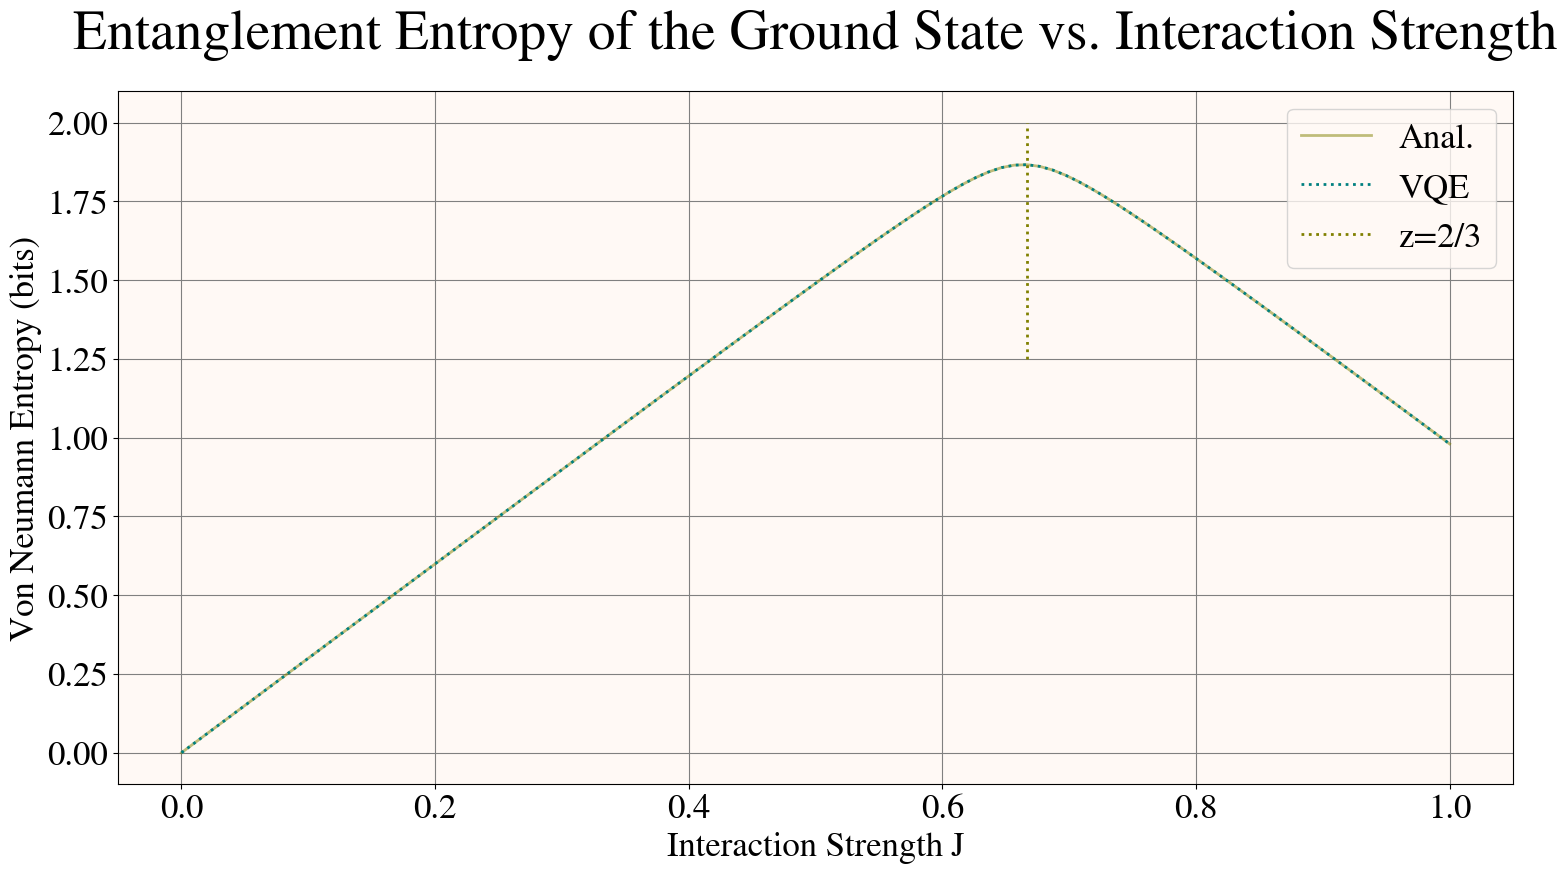

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Pauli matrices
I = np.eye(2, dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

def build_lipkin_J0(E1, E2, V11, V22, V12, l=1):
    """Build 2x2 Lipkin Hamiltonian for the simple 2-level case"""
    epsilon = 0.5*(E2 + E1)
    omega = 0.5*(E1 - E2)
    c = 0.5*(V11 + V22)
    wz = 0.5*(V11 - V22)
    wx = V12
    
    H0 = epsilon*I + omega*Z
    HI = c*I + wz*Z + wx*X
    return H0 + l*HI

def ansatz(params):
    """Single-qubit ansatz for 2x2 case"""
    theta, phi = params
    return np.array([
        np.cos(theta/2),
        np.exp(1j*phi)*np.sin(theta/2)
    ], dtype=complex)

def measure_energy(state, H, shots=1000):
    """Measurement-based energy calculation for 2x2 system"""
    # Decompose Hamiltonian into Pauli terms
    coeffs = [
        0.5*np.trace(H @ I).real,  # I coefficient
        0.5*np.trace(H @ X).real,   # X coefficient
        0.5*np.trace(H @ Z).real    # Z coefficient
    ]
    
    # Measure expectation values
    expec_I = 1.0  # Identity contribution
    expec_X = 2*np.real(state[0].conj()*state[1])
    expec_Z = np.abs(state[0])**2 - np.abs(state[1])**2
    
    return sum([coeffs[0]*expec_I,
                coeffs[1]*expec_X,
                coeffs[2]*expec_Z])

def run_vqe_2level(E1, E2, V11, V22, V12, l=1, n_restarts=5):
    H = build_lipkin_J0(E1, E2, V11, V22, V12, l)
    exact_energy = np.min(np.linalg.eigvalsh(H))
    
    best_energy = np.inf
    for _ in range(n_restarts):
        params = np.random.uniform(0, 2*np.pi, 2)
        res = minimize(lambda p: measure_energy(ansatz(p), H),
                       params, method='Nelder-Mead')
        if res.fun < best_energy:
            best_energy = res.fun
    
    return exact_energy, best_energy


E1 = 0
E2 = 4
V11 = 3
V22 = -V11
V12 = 0.2
energies = []
VQEenergies = []
for J in J_values:
    exact, vqe = run_vqe_2level(E1, E2, V11, V22, V12,l=J)
    VQEenergies.append(vqe)
    
    energies.append(exact)

# Plot the von Neumann entropy as a function of the interaction strength J
plt.plot(J_values, energies, alpha=0.5,label="Anal.")
plt.plot(J_values, VQEenergies, ls="dotted",label="VQE")
plt.vlines(2/3,1.25,2,ls="dotted",label="z=2/3")
plt.xlabel("Interaction Strength J")
plt.ylabel("Von Neumann Entropy (bits)")
plt.title("Entanglement Entropy of the Ground State vs. Interaction Strength")
plt.legend()
plt.grid(True)
plt.show()


<h2 style="font-family:Times New Roman; font-weight:bolder">Error Analysis</h2>

<p style="font-family:Times New Roman; font-size:120%">
    For completeness, I show explicitly that the error resulting is essentially zero.
</p>

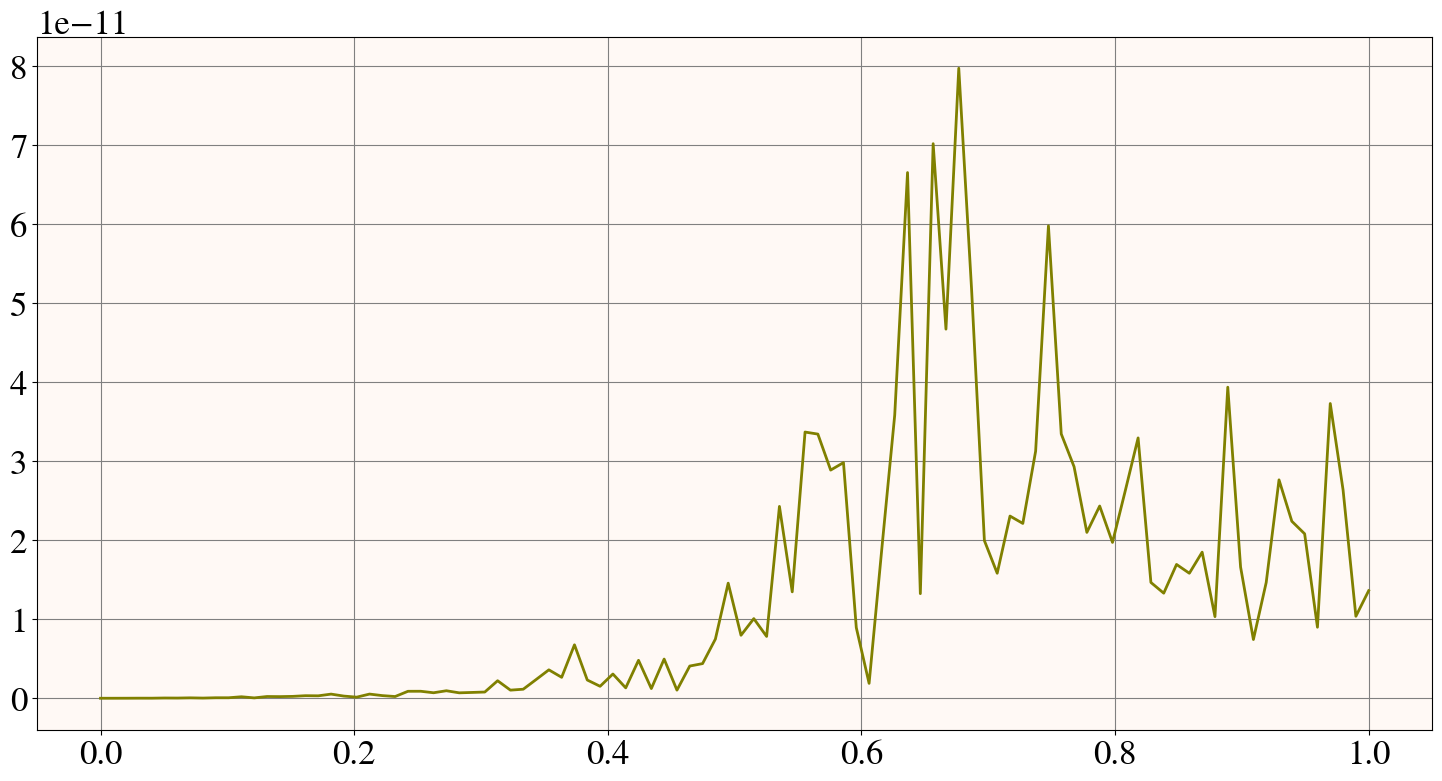

In [72]:
err = abs(np.array(VQEenergies) - np.array(energies))/np.array(exact_energy)

plt.plot(J_values,err)

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Task d:</h2>

<p style="font-family:Times New Roman; font-size:120%">
    Here we analyze the entropy, which at interaction strength 0.4 suddenly jumps up. This comes from the fact that the energy between
</p>

In [8]:
Hx=2.0
Hz=3.0
H0_eigens = np.array([0.0, 2.5, 6.5, 7.0])

def Ham2Q(Hx, Hz, eigs, J=1.0):
    Hz_d = np.diag(np.array([1,-1,-1,1])*Hz)
    Hx_aD = np.fliplr(np.diag(np.array([1,1,1,1])*Hx))
    Dig = np.diag(eigs)+J*(Hz_d +Hx_aD)
    return Dig

In [9]:
# Construct the Hamiltonian
H = Ham2Q(Hx, Hz, H0_eigens)

# Diagonalize the Hamiltonian
eigvals, eigvecs = np.linalg.eigh(H)

# Select the ground state eigenvector (lowest eigenvalue)
psi_ground = eigvecs[:, 0]

# Construct the density matrix from the ground state |ψ><ψ|
rho = np.outer(psi_ground, np.conjugate(psi_ground))

# Define a function to perform the partial trace over qubit B (i.e., trace out the second qubit)
def partial_trace_qubit_B(rho):
    rho_A = np.zeros((2, 2), dtype=complex)
    # Loop over indices for qubit A (i and j) and sum over qubit B (k)
    for i in range(2):
        for j in range(2):
            # For each qubit A element, sum over the corresponding two indices of qubit B:
            rho_A[i, j] = rho[i * 2 + 0, j * 2 + 0] + rho[i * 2 + 1, j * 2 + 1]
    return rho_A

# Obtain the reduced density matrix for qubit A
rho_A = partial_trace_qubit_B(rho)

# Define a function to compute the von Neumann entropy
def von_neumann_entropy(rho, base=2):
    eigenvals = np.linalg.eigvals(rho)
    # Take only the real part (they should be real up to numerical precision)
    eigenvals = np.real(eigenvals)
    # Filter out eigenvalues that are essentially zero to avoid log(0)
    eigenvals = eigenvals[eigenvals > 1e-12]
    entropy = -np.sum(eigenvals * np.log(eigenvals) / np.log(base))
    return entropy

# Compute the von Neumann entropy of the reduced density matrix
entropy = von_neumann_entropy(rho_A)

print("Von Neumann Entropy (entanglement entropy) =", entropy)

Von Neumann Entropy (entanglement entropy) = 0.6008760366928562


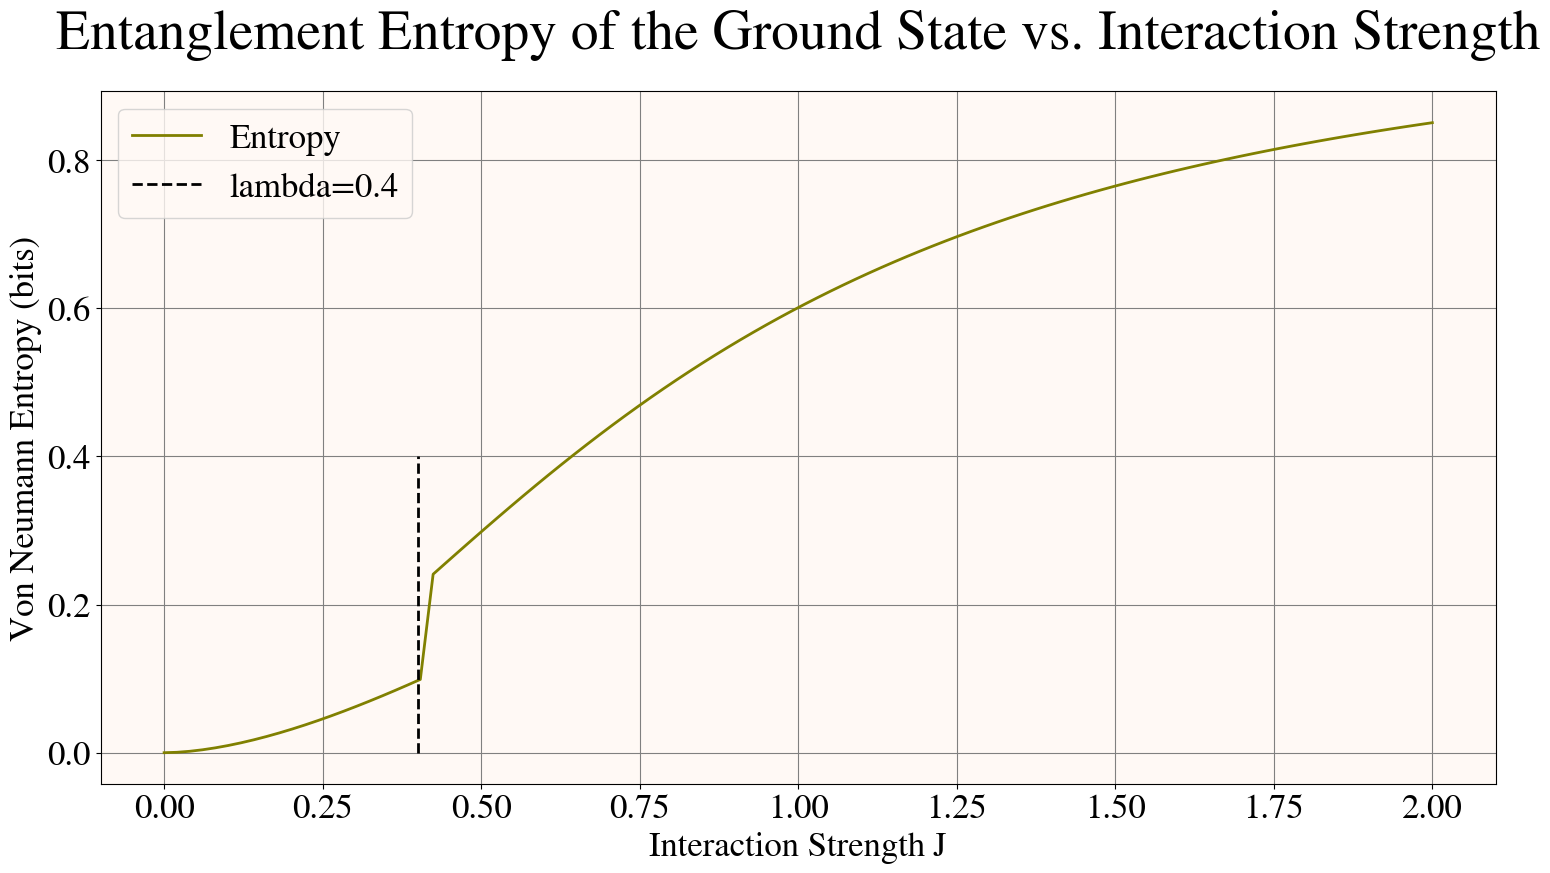

In [10]:

# Set up a range of interaction strengths J
J_values = np.linspace(0, 2, 100)
entropies = []
for (i,J) in enumerate(J_values):
    # Construct the Hamiltonian
    H = Ham2Q(Hx, Hz, H0_eigens,J)
    
    # Diagonalize the Hamiltonian
    eigvals, eigvecs = np.linalg.eigh(H)
    # Select the ground state eigenvector (lowest eigenvalue)
    psi_ground = eigvecs[:, 0]
    
    # Construct the density matrix from the ground state |ψ><ψ|
    rho = np.outer(psi_ground, np.conjugate(psi_ground))
    rho_A = partial_trace_qubit_B(rho)
    entropy = von_neumann_entropy(rho_A)
    eigvals, _ = np.linalg.eigh(rho_A)
    entropies.append(entropy)

# Plot the von Neumann entropy as a function of the interaction strength J
plt.plot(J_values, entropies, label="Entropy")
plt.vlines(0.4,0,0.4,ls="dashed",color="k",label="lambda=0.4")
plt.xlabel("Interaction Strength J")
plt.ylabel("Von Neumann Entropy (bits)")
plt.title("Entanglement Entropy of the Ground State vs. Interaction Strength")
plt.legend()
plt.grid(True)
plt.show()


<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Task e:</h2>

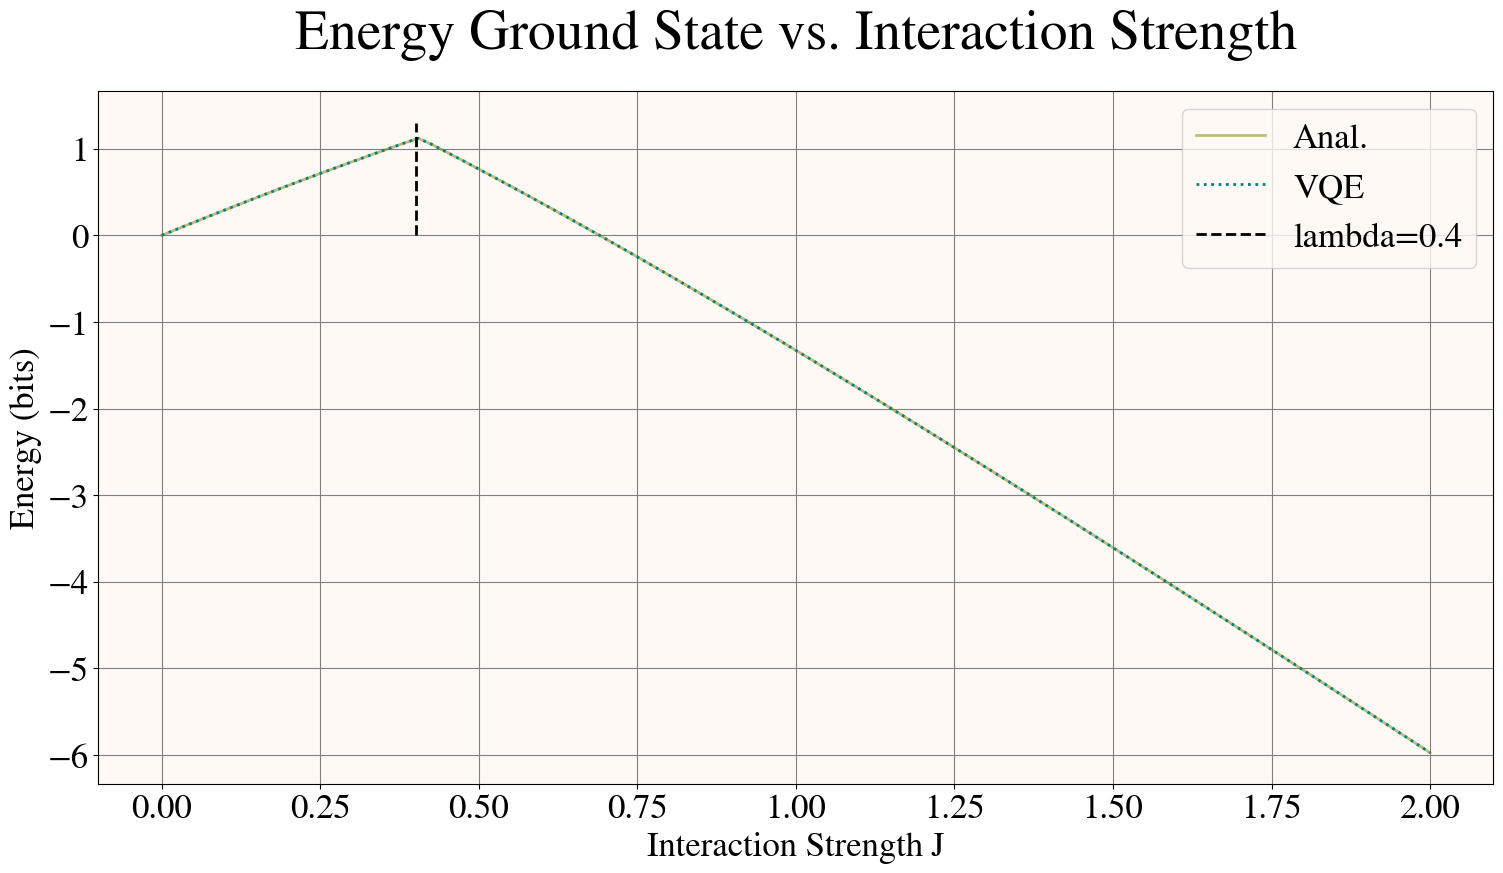

In [11]:
Hx=2.0
Hz=3.0
H0_eigens = np.array([0.0, 2.5, 6.5, 7.0])

def Ham2Q(Hx, Hz, eigs, J=1.0):
    Hz_d = np.diag(np.array([1,-1,-1,1])*Hz)
    Hx_aD = np.fliplr(np.diag(np.array([1,1,1,1])*Hx))
    Dig = np.diag(eigs)+J*(Hz_d +Hx_aD)
    return Dig
# Set up a range of interaction strengths J
J_values = np.linspace(0, 2, 100)
energies = []
VQEenergies = []
def ansatz_two_qubit(params):
    theta1, theta2, theta3, theta4 = params
    # Initial state |00>
    state = np.array([1, 0, 0, 0], dtype=complex)
    # First layer: apply R_y on each qubit
    U1 = np.kron(R_y(theta1), R_y(theta2))
    state = U1 @ state
    # Entangling layer: apply CNOT
    state = CNOT @ state
    # Second layer: apply R_y on each qubit
    U2 = np.kron(R_y(theta3), R_y(theta4))
    state = U2 @ state
    return state
    
def energy_expectation_two_qubit(params):
    psi = ansatz_two_qubit(params)
    return np.real(np.vdot(psi, H_two_qubit @ psi))
    
def R_y(theta):
    return np.array([[np.cos(theta/2), -np.sin(theta/2)],
                     [np.sin(theta/2),  np.cos(theta/2)]], dtype=complex)

for J in J_values:
    # Initial guess for the four parameters
    initial_params = [np.pi/4, np.pi/4, np.pi/4, np.pi/4]
    # Construct the Hamiltonian
    H_two_qubit = Ham2Q(Hx, Hz, H0_eigens,J)
    
    # Optimize the energy using a classical optimizer
    result_2q = minimize(energy_expectation_two_qubit, initial_params, method='Nelder-Mead')
    params_opt = result_2q.x
    vqe_energy_2q = energy_expectation_two_qubit(params_opt)
    
    # Exact diagonalization for comparison
    eigvals_2q, _ = np.linalg.eigh(H_two_qubit)
    exact_energy_2q = np.min(eigvals_2q)


    VQEenergies.append(vqe_energy_2q)
    energies.append(exact_energy_2q)

# Plot the von Neumann entropy as a function of the interaction strength J
plt.plot(J_values, energies, alpha=0.5,label="Anal.")
plt.plot(J_values, VQEenergies, ls="dotted",label="VQE")
plt.vlines(0.4,0,1.3,ls="dashed",color="k",label="lambda=0.4")
plt.xlabel("Interaction Strength J")
plt.ylabel("Energy (bits)")
plt.title("Energy Ground State vs. Interaction Strength")
plt.grid(True)
plt.legend()
plt.show()

J=0.00 | Exact: 0.0000, Measured VQE: 0.0000
J=0.11 | Exact: 0.3095, Measured VQE: 0.3057
J=0.21 | Exact: 0.6063, Measured VQE: 0.5823
J=0.32 | Exact: 0.8908, Measured VQE: 0.8331
J=0.42 | Exact: 1.0668, Measured VQE: -1.5857
J=0.53 | Exact: 0.6610, Measured VQE: -2.0602
J=0.63 | Exact: 0.2398, Measured VQE: -2.5767
J=0.74 | Exact: -0.1948, Measured VQE: -3.0863
J=0.84 | Exact: -0.6410, Measured VQE: -3.6138
J=0.95 | Exact: -1.0971, Measured VQE: -4.1358
J=1.05 | Exact: -1.5617, Measured VQE: -4.6931
J=1.16 | Exact: -2.0336, Measured VQE: -5.2249
J=1.26 | Exact: -2.5116, Measured VQE: -5.7600
J=1.37 | Exact: -2.9950, Measured VQE: -6.3005
J=1.47 | Exact: -3.4829, Measured VQE: -6.8461
J=1.58 | Exact: -3.9748, Measured VQE: -7.4125
J=1.68 | Exact: -4.4701, Measured VQE: -7.9562
J=1.79 | Exact: -4.9683, Measured VQE: -8.4893
J=1.89 | Exact: -5.4691, Measured VQE: -9.0303
J=2.00 | Exact: -5.9721, Measured VQE: -9.5816


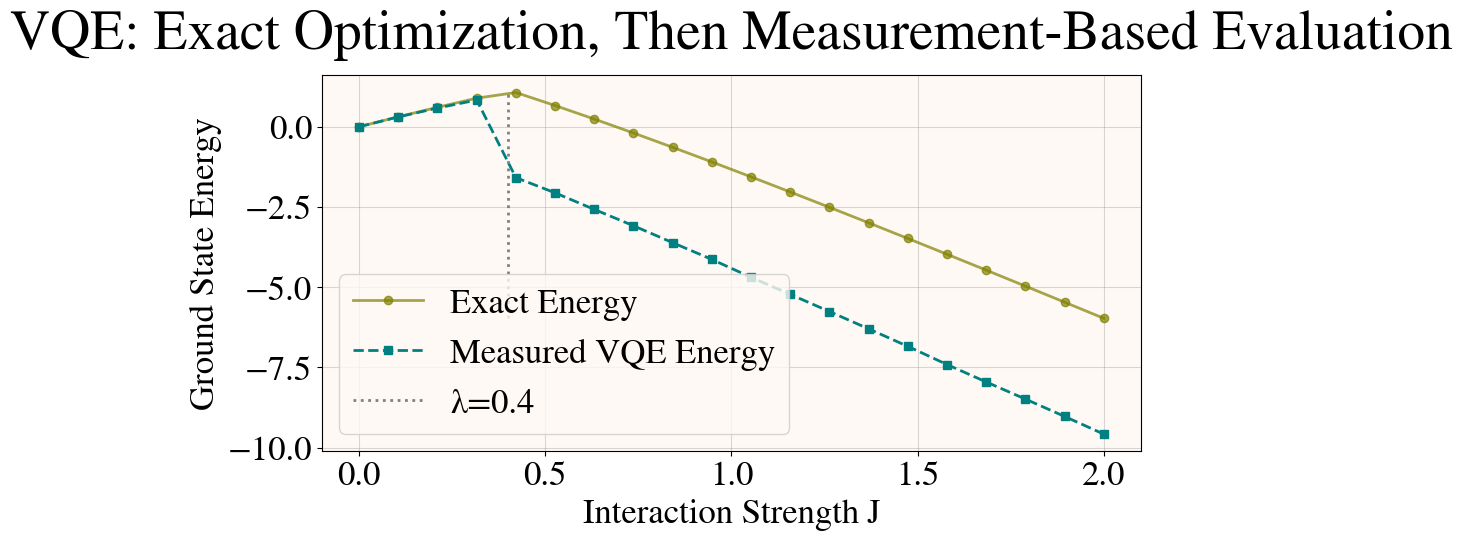

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from itertools import product

# ============== 1. Quantum Operators ==============
I = np.eye(2, dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

# Left qubit = qubit 0, right qubit = qubit 1
CNOT = np.array([
    [1, 0, 0, 0],  # |00> -> |00>
    [0, 1, 0, 0],  # |01> -> |01>
    [0, 0, 0, 1],  # |10> -> |11>
    [0, 0, 1, 0]   # |11> -> |10>
], dtype=complex)

# ============== 2. Your Hamiltonian ==============
Hx = 2.0
Hz = 3.0
H0_eigens = np.array([0.0, 2.5, 6.5, 7.0])

def Ham2Q(Hx, Hz, eigs, J=1.0):
    """
    Build your custom 2-qubit Hamiltonian:
      diag(eigs) + J*(Hz_d + Hx_aD)
    """
    Hz_d = np.diag(np.array([1, -1, -1, 1]) * Hz)
    Hx_aD = np.fliplr(np.diag(np.array([1, 1, 1, 1]) * Hx))
    return np.diag(eigs) + J * (Hz_d + Hx_aD)

# ============== 3. Measurement System ==============
def pauli_decompose(H):
    """
    Decompose H into (coefficient, pauli_str), e.g. (0.3, 'XZ').
    For 2 qubits, each term is 1/4 * trace(H * (p1⊗p2)).
    """
    basis = {'I': I, 'X': X, 'Y': Y, 'Z': Z}
    terms = []
    for p1, p2 in product(basis.keys(), repeat=2):
        mat = np.kron(basis[p1], basis[p2])
        coeff = np.trace(H @ mat).real / 4.0
        if abs(coeff) > 1e-8:
            terms.append((coeff, p1 + p2))
    return terms

def measure_pauli(state, pauli_str, shots=10000):
    """
    Simulate shot-based measurement for the 2-qubit state in the Pauli basis.
    pauli_str[0] => left qubit (qubit 0), pauli_str[1] => right qubit (qubit 1).
    """
    rotated_state = state.copy()

    # For each qubit, rotate to Z if measuring X or Y
    for qubit, pauli in enumerate(pauli_str):
        if pauli == 'X':
            H_gate = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
            rot = np.kron(H_gate, I) if qubit == 0 else np.kron(I, H_gate)
            rotated_state = rot @ rotated_state
        elif pauli == 'Y':
            Sdg = np.array([[1, 0], [0, -1j]])
            H_gate = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
            Y_rot = Sdg @ H_gate
            rot = np.kron(Y_rot, I) if qubit == 0 else np.kron(I, Y_rot)
            rotated_state = rot @ rotated_state
        # If pauli == 'Z' or 'I', do nothing

    # Probabilities in computational basis
    probs = np.abs(rotated_state)**2
    probs /= probs.sum()
    samples = np.random.choice(4, size=shots, p=probs)

    # index => eigenvalue = (-1)^(# of 1 bits in index)
    expectation = 0.0
    for i in range(4):
        bitcount = bin(i).count('1')
        eigenval = (-1)**bitcount
        fraction = np.count_nonzero(samples == i) / shots
        expectation += eigenval * fraction

    return expectation

def measure_energy(state, H, shots=10000):
    """
    Evaluate ⟨H⟩ by decomposing into Pauli terms and measuring each one.
    """
    terms = pauli_decompose(H)
    E = 0.0
    for coeff, pauli_str in terms:
        E += coeff * measure_pauli(state, pauli_str, shots)
    return E

# ============== 4. Ansatz and Direct Energy ==============
def Ry(theta):
    return np.array([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2),  np.cos(theta/2)]
    ], dtype=complex)

def ansatz_two_qubit(params):
    """
    4-parameter ansatz: 
      - left qubit gets θ1, right qubit gets θ2
      - entangle with CNOT
      - left qubit gets θ3, right qubit gets θ4
    """
    theta1, theta2, theta3, theta4 = params
    # Start in |00>
    state = np.array([1, 0, 0, 0], dtype=complex)

    # First layer
    U1 = np.kron(Ry(theta1), Ry(theta2))
    state = U1 @ state

    # Entangling
    state = CNOT @ state

    # Second layer
    U2 = np.kron(Ry(theta3), Ry(theta4))
    state = U2 @ state

    return state

def direct_cost(params, H):
    """
    Direct energy:  ψ(θ)† H ψ(θ).
    This is used by the optimizer (NOT measurement-based).
    """
    psi = ansatz_two_qubit(params)
    return np.real(np.vdot(psi, H @ psi))

# ============== 5. Main: Optimize via direct_cost, then measure ==============
if __name__ == "__main__":
    J_values = np.linspace(0, 2, 20)
    exact_energies = []
    vqe_measured_energies = []

    for J in J_values:
        # 1) Build Hamiltonian
        H = Ham2Q(Hx, Hz, H0_eigens, J)

        # 2) Exact energy
        eigvals, _ = np.linalg.eigh(H)
        exact_energy = np.min(eigvals)
        exact_energies.append(exact_energy)

        # 3) Optimize direct cost to get best params
        init_params = [np.pi/4]*4
        opt_result = minimize(lambda p: direct_cost(p, H),
                              init_params, method='Nelder-Mead')
        best_params = opt_result.x

        # 4) AFTER optimization, measure the final state with shots
        final_state = ansatz_two_qubit(best_params)
        measured_energy = measure_energy(final_state, H, shots=20000)
        vqe_measured_energies.append(measured_energy)

        print(f"J={J:.2f} | Exact: {exact_energy:.4f}, "
              f"Measured VQE: {measured_energy:.4f}")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(J_values, exact_energies, 'o-', label="Exact Energy", alpha=0.7)
    plt.plot(J_values, vqe_measured_energies, 's--', label="Measured VQE Energy")
    plt.vlines(0.4, min(exact_energies), max(exact_energies), 
               ls=":", color='gray', label="λ=0.4")
    plt.xlabel("Interaction Strength J")
    plt.ylabel("Ground State Energy")
    plt.title("VQE: Exact Optimization, Then Measurement-Based Evaluation")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Task f:</h2>
<p style="font-family:Times New Roman; font-size:120%">
    We will now work with the full Lipkin model, I create the Hamiltonian matrix by acting the J operators on the basis functions. J can be set to both 1 and 2 here.
</p>

In [12]:
###############################################################################
# 1. PAULI MATRICES AND UTILITIES
###############################################################################
I_1 = np.array([[1,0],[0,1]], dtype=complex)
X_1 = np.array([[0,1],[1,0]], dtype=complex)
Y_1 = np.array([[0,-1j],[1j,0]], dtype=complex)
Z_1 = np.array([[1,0],[0,-1]], dtype=complex)

def kron2(A, B):
    """2-fold Kronecker product for 2x2 operators, yields a 4x4."""
    return np.kron(A,B)

def kron3(A, B, C):
    """3-fold Kronecker product for 2x2 operators, yields an 8x8."""
    return np.kron(A, np.kron(B,C))

def project_subspace(H_full, subspace):
    """
    Extract sub-block of 'H_full' given the list of 'subspace' indices.
    Returns the projected matrix of shape (len(subspace), len(subspace)).
    """
    return H_full[np.ix_(subspace, subspace)]


###############################################################################
# 2. LIPKIN HAMILTONIANS FROM PAULI SUMS
###############################################################################
def lipkin_j1_pauli(eps, V):
    """
    Builds a 4x4 operator for the J=1 Lipkin Hamiltonian in a two-qubit space,
    using sums of Pauli operators. Then projects onto the subspace spanned by
    |00>, |01>, |10>, yielding a 3x3 matrix.
    
    We use the known expression (up to sign conventions):
      H_{3x3} = -eps * (Z⊗I) - (V/2)* [ (X⊗X) + (Y⊗Y) ],
    in the subspace of dimension 3. 
    """
    # Build full 4x4 operator in 2-qubit space
    # (Note that sign conventions may differ; you can adjust if needed.)
    H_4 = (
        -eps * kron2(Z_1, I_1)
        - 0.5*V * (kron2(X_1, X_1) + kron2(Y_1, Y_1))
    )
    
    # The subspace for J=1 is spanned by |00> (m=-1), |01> (m=0), |10> (m=+1).
    subspace = [0,1,2]  # indices in the 2-qubit basis
    H_3x3 = project_subspace(H_4, subspace)
    return H_3x3


###############################################################################
# Build the J=2 Hamiltonian from Pauli operators
###############################################################################
def lipkin_j2_pauli(eps, V):
    r"""
    Builds the J=2 Lipkin Hamiltonian (5x5) by:
      1) Constructing the even block (3x3) from a 4x4 two-qubit operator
         H_even_4 = -ε(Z⊗I) + (√6 V / 2)(X⊗X + Y⊗Y),
         then projecting onto |00>,|01>,|10> -> subspace indices [0,1,2].
      2) Constructing the odd block (2x2) from a single-qubit operator
         H_odd_2 = 3V X - ε Z.
      3) Combining them into a 5x5 block diagonal matrix.
    """
    # --------------------- Even Block (3x3) ---------------------
    # 4x4 operator in two-qubit space
    H_even_4x4 = (
        -eps * (kron2(Z_1, I_1)+kron2(Z_1,Z_1))
        + (np.sqrt(6)*V/2.0) * (kron2(I_1,X_1)+kron2(Z_1,X_1)+kron2(X_1, X_1) + kron2(Y_1, Y_1))
    )
    # Project onto subspace [0,1,2] = {|00>, |01>, |10>}
    subspace_even = [0,1,2]
    H_even_3x3 = project_subspace(H_even_4x4, subspace_even)

    # --------------------- Odd Block (2x2) ----------------------
    # Single-qubit operator
    H_odd_2x2 = 3.0*V * X_1  - eps * Z_1

    # --------------------- Combine into 5x5 ---------------------
    H_5x5 = np.block([
        [H_even_3x3,                np.zeros((3,2), dtype=complex)],
        [np.zeros((2,3), dtype=complex),  H_odd_2x2]
    ])
    return H_5x5
def build_lipkin(J, eps, V):
    """
    Convenience function: returns the final Hamiltonian matrix for J=1 or J=2,
    built from the Pauli-based approach, with dimension 3x3 (J=1) or 5x5 (J=2).
    """
    if J == 1:
        return lipkin_j1_pauli(eps, V)
    elif J == 2:
        return lipkin_j2_pauli(eps, V)
    else:
        raise ValueError("This code supports only J=1 or J=2.")


In [13]:
# Example: J=1
J = 1
eps = 1.0  # single-particle energy
V_values = np.linspace(0, 3, 6)  # some range of V

for V in V_values:
    H =   build_lipkin(J, eps, V)
    eigvals, eigvecs = np.linalg.eigh(H)
    print(f"\nV = {V}")
    print("Eigenvalues:", np.round(eigvals, 4))
    print("Ground State Energy:", np.round(eigvals[0], 4))



V = 0.0
Eigenvalues: [-1. -1.  1.]
Ground State Energy: -1.0

V = 0.6
Eigenvalues: [-1.166 -1.     1.166]
Ground State Energy: -1.1662

V = 1.2
Eigenvalues: [-1.562 -1.     1.562]
Ground State Energy: -1.562

V = 1.7999999999999998
Eigenvalues: [-2.059 -1.     2.059]
Ground State Energy: -2.0591

V = 2.4
Eigenvalues: [-2.6 -1.   2.6]
Ground State Energy: -2.6

V = 3.0
Eigenvalues: [-3.162 -1.     3.162]
Ground State Energy: -3.1623


In [14]:
# Example: J=2
J = 2
eps = 1.0  # single-particle energy
V_values = np.linspace(0, 3, 6)  # some range of V

for V in V_values:
    H =   build_lipkin(J, eps, V)
    eigvals, eigvecs = np.linalg.eigh(H)
    print(f"\nV = {V}")
    print("Eigenvalues:", np.round(eigvals, 4))
    print("Ground State Energy:", np.round(eigvals[0], 4))



V = 0.0
Eigenvalues: [-2. -1.  0.  1.  2.]
Ground State Energy: -2.0

V = 0.6
Eigenvalues: [-2.884 -2.059 -0.     2.059  2.884]
Ground State Energy: -2.8844

V = 1.2
Eigenvalues: [-4.613 -3.736  0.     3.736  4.613]
Ground State Energy: -4.613

V = 1.7999999999999998
Eigenvalues: [-6.548 -5.492 -0.     5.492  6.548]
Ground State Energy: -6.5483

V = 2.4
Eigenvalues: [-8.551 -7.269 -0.     7.269  8.551]
Ground State Energy: -8.551

V = 3.0
Eigenvalues: [-10.583  -9.055  -0.      9.055  10.583]
Ground State Energy: -10.583


<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Task g:</h2>

J=1, V=0.00 | Exact: -1.000000, VQE: -1.000000
J=1, V=0.75 | Exact: -1.000000, VQE: -1.058250
J=1, V=1.50 | Exact: -1.500000, VQE: -1.483500
J=1, V=2.25 | Exact: -2.250000, VQE: -2.320000
J=1, V=3.00 | Exact: -3.000000, VQE: -3.077000
J=2, V=0.00 | Exact: -2.000000, VQE: -2.000000
J=2, V=0.75 | Exact: -3.278719, VQE: -3.278711
J=2, V=1.50 | Exact: -5.567764, VQE: -5.567467
J=2, V=2.25 | Exact: -8.046738, VQE: -8.046648
J=2, V=3.00 | Exact: -10.583005, VQE: -10.583005


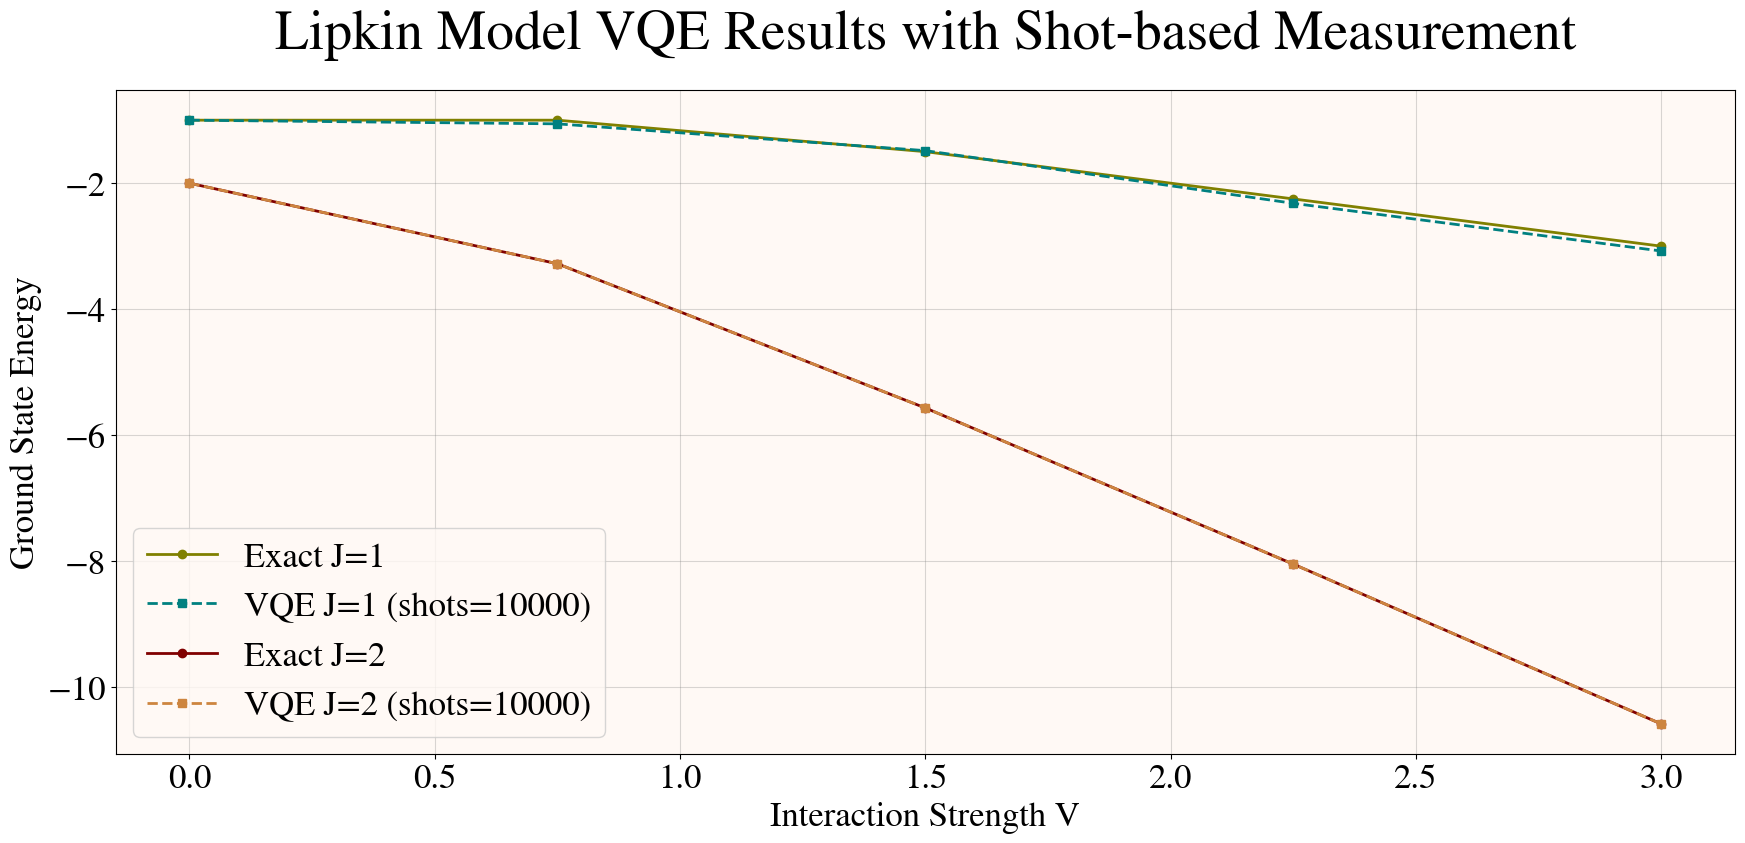

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from itertools import product

###############################################################################
# 1. Pauli matrices and helper functions
###############################################################################
I = np.eye(2, dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

def kron2(a, b):
    return np.kron(a, b)

def project_subspace(matrix, subspace):
    return matrix[np.ix_(subspace, subspace)]

def pauli_decompose(matrix):
    """Decompose matrix into Pauli terms (coefficient, string)"""
    n_qubits = int(np.log2(matrix.shape[0]))
    basis = {'I': I, 'X': X, 'Y': Y, 'Z': Z}
    terms = []
    for pauli_str in product(basis.keys(), repeat=n_qubits):
        pauli_str = ''.join(pauli_str)
        pauli_mat = basis[pauli_str[0]]
        for p in pauli_str[1:]:
            pauli_mat = kron2(pauli_mat, basis[p])
        coeff = np.trace(matrix @ pauli_mat) / (2**n_qubits)
        if not np.isclose(coeff, 0, atol=1e-8):
            terms.append((coeff.real, pauli_str))
    return terms

###############################################################################
# 2. Build Lipkin Hamiltonians from Pauli sums
###############################################################################
def build_lipkin(J, eps, V):
    if J == 1:
        # J=1: Build a 4x4 operator in two-qubit space:
        # H = -eps/2*(Z⊗I + I⊗Z) + V/2*(X⊗X + Y⊗Y)
        H = np.zeros((4,4), dtype=complex)
        H += -eps/2 * (kron2(Z, I) + kron2(I, Z))
        H += V/2 * (kron2(X, X) + kron2(Y, Y))
        # Return the full 4x4 operator (ansatz will produce a 4D state)
        return H
    elif J == 2:
        # J=2: Even block (3x3) and Odd block (2x2)
        H_even_4x4 = (
            -eps * (kron2(Z, I) + kron2(Z, Z)) 
            + (np.sqrt(6)*V/2) * (kron2(I, X) + kron2(Z, X) + kron2(X, X) + kron2(Y, Y))
        )
        H_even = project_subspace(H_even_4x4, [0,1,2])
        H_odd = 3*V*X - eps*Z
        H = np.block([
            [H_even, np.zeros((3,2))],
            [np.zeros((2,3)), H_odd]
        ])
        return H
    else:
        raise ValueError("This code supports only J=1 or J=2.")

###############################################################################
# 3. Variational Ansatz Functions
###############################################################################
def ansatz(params, J):
    if J == 1:
        # NEW: 4-parameter ansatz for J=1, building a general 2-qubit state.
        # Use R_y and R_z rotations on each qubit.
        # For qubit 0: R_y(theta1) R_z(theta2)
        # For qubit 1: R_y(theta3) R_z(theta4)
        theta1, theta2, theta3, theta4 = params[:4]
        # Define single-qubit rotation: R_y(theta) R_z(phi)
        R_y = np.array([[np.cos(theta1/2), -np.sin(theta1/2)],
                        [np.sin(theta1/2),  np.cos(theta1/2)]], dtype=complex)
        # Instead, we construct rotations separately for each qubit:
        R0 = np.array([[np.cos(theta1/2), -np.sin(theta1/2)*np.exp(1j*theta2)],
                       [np.sin(theta1/2),  np.cos(theta1/2)*np.exp(1j*theta2)]], dtype=complex)
        R1 = np.array([[np.cos(theta3/2), -np.sin(theta3/2)*np.exp(1j*theta4)],
                       [np.sin(theta3/2),  np.cos(theta3/2)*np.exp(1j*theta4)]], dtype=complex)
        state = np.kron([1,0], [1,0])
        state = np.kron(R0, R1) @ state
        return state
    elif J == 2:
        # 8-parameter ansatz for J=2: returns a 5-dimensional state.
        if len(params) < 8:
            raise ValueError("Need 8 parameters for J=2.")
        theta1, theta2, theta3, theta4, phi1, phi2, phi3, phi4 = params[:8]
        st = np.array([
            np.cos(theta1),
            np.sin(theta1)*np.cos(theta2)*np.exp(1j*phi1),
            np.sin(theta1)*np.sin(theta2)*np.cos(theta3)*np.exp(1j*phi2),
            np.sin(theta1)*np.sin(theta2)*np.sin(theta3)*np.cos(theta4)*np.exp(1j*phi3),
            np.sin(theta1)*np.sin(theta2)*np.sin(theta3)*np.sin(theta4)*np.exp(1j*phi4)
        ], dtype=complex)
        return st / np.linalg.norm(st)
    else:
        raise ValueError("J must be 1 or 2.")

def ansatz_state(J, params):
    return ansatz(params, J)

###############################################################################
# 4. Measurement-Based Energy Evaluation
###############################################################################
def measure_pauli(state, pauli_str, shots=1000):
    """Measure state in Pauli basis with given shots."""
    n_qubits = len(pauli_str)
    rotated_state = state.copy()
    for qubit, pauli in enumerate(reversed(pauli_str)):  # Qubit 0 is rightmost
        if pauli == 'X':
            H_gate = np.array([[1, 1], [1, -1]])/np.sqrt(2)
            rot = np.kron(np.eye(2**qubit), np.kron(H_gate, np.eye(2**(n_qubits-qubit-1))))
            rotated_state = rot @ rotated_state
        elif pauli == 'Y':
            Sdg = np.array([[1, 0], [0, -1j]])
            H_gate = np.array([[1, 1], [1, -1]])/np.sqrt(2)
            rot = np.kron(np.eye(2**qubit), np.kron(Sdg @ H_gate, np.eye(2**(n_qubits-qubit-1))))
            rotated_state = rot @ rotated_state
    probs = np.abs(rotated_state)**2
    cum_probs = np.cumsum(probs)
    counts = np.zeros(len(probs))
    for _ in range(shots):
        r = np.random.rand()
        for i, cp in enumerate(cum_probs):
            if r < cp:
                counts[i] += 1
                break
    measurements = counts/shots
    return np.sum([(-1)**bin(i).count('1') * measurements[i] for i in range(len(measurements))])

def measure_energy(state, terms, shots=1000):
    """Calculate energy from Pauli terms using shot-based measurements."""
    energy = 0.0
    for coeff, pauli_str in terms:
        expectation = measure_pauli(state, pauli_str, shots)
        energy += coeff * expectation
    return energy

def pauli_decompose(matrix):
    """Decompose matrix into Pauli terms (coefficient, string)."""
    n_qubits = int(np.log2(matrix.shape[0]))
    basis = {'I': I, 'X': X, 'Y': Y, 'Z': Z}
    terms = []
    for pauli_str in product(basis.keys(), repeat=n_qubits):
        pauli_str = ''.join(pauli_str)
        pauli_mat = basis[pauli_str[0]]
        for p in pauli_str[1:]:
            pauli_mat = kron2(pauli_mat, basis[p])
        coeff = np.trace(matrix @ pauli_mat) / (2**n_qubits)
        if not np.isclose(coeff, 0, atol=1e-8):
            terms.append((coeff.real, pauli_str))
    return terms

def energy_function(J, params, H):
    if J == 1:
        return measure_energy(ansatz(params, J), pauli_decompose(H), shots=1000)
    elif J == 2:
        psi = ansatz(params, J)
        return np.real(np.vdot(psi, H @ psi))
    else:
        raise ValueError("J must be 1 or 2.")

###############################################################################
# 5. VQE Routine
###############################################################################
def run_vqe_separate(J, eps, V_values, shots=1000, n_restarts=3):
    param_dim = 4 if J == 1 else 8  # For J=1 we now use 4 parameters.
    exact_energies = []
    vqe_energies = []
    
    for V in V_values:
        H = build_lipkin(J, eps, V)
        exact_energy = np.min(np.linalg.eigvalsh(H))
        exact_energies.append(exact_energy)
        
        best_energy = np.inf
        for _ in range(n_restarts):
            params = np.random.uniform(0, 2*np.pi, param_dim)
            res = minimize(lambda p: energy_function(J, p, H),
                           params, method='Nelder-Mead', options={'maxiter':200})
            if res.fun < best_energy:
                best_energy = res.fun
        vqe_energies.append(best_energy)
        print(f"J={J}, V={V:.2f} | Exact: {exact_energy:.6f}, VQE: {best_energy:.6f}")
    
    return V_values, exact_energies, vqe_energies

###############################################################################
# 6. Main Execution and Plotting
###############################################################################
if __name__ == "__main__":
    eps = 1.0
    V_values = np.linspace(0, 3, 5)
    shots = 10000  # Increase shots to reduce statistical error
    
    for J in [1, 2]:
        Vs, exact, vqe = run_vqe_separate(J, eps, V_values, shots)
        plt.plot(Vs, exact, 'o-', label=f"Exact J={J}")
        plt.plot(Vs, vqe, 's--', label=f"VQE J={J} (shots={shots})")
        
    plt.xlabel("Interaction Strength V")
    plt.ylabel("Ground State Energy")
    plt.title("Lipkin Model VQE Results with Shot-based Measurement")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
